# Projekt ZUM - Streszczenie tekstu

## Wstępna analiza

In [81]:
! pip install datasets transformers torch accelerate dash plotly jupyter-dash rouge-score evaluate

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [82]:
from datasets import load_dataset

ds = load_dataset("abisee/cnn_dailymail", "3.0.0")
cap = 700
df_train = ds['train'].to_pandas()
df_train = df_train[df_train['article'].str.len() < cap]

df_val = ds['validation'].to_pandas()
df_val = df_val[df_val['article'].str.len() < cap]

df_test = ds['test'].to_pandas()
df_test = df_test[df_test['article'].str.len() < cap]

In [83]:
ds

DatasetDict({
    train: Dataset({
        features: ['article', 'highlights', 'id'],
        num_rows: 287113
    })
    validation: Dataset({
        features: ['article', 'highlights', 'id'],
        num_rows: 13368
    })
    test: Dataset({
        features: ['article', 'highlights', 'id'],
        num_rows: 11490
    })
})

In [84]:
import pandas as pd

pd.set_option('display.max_colwidth', 500)

df_train

,article,highlights,id
293,• The twins get a check-up (2/26/08) • VIDEO: Nancy Grace introduces on set 2-14-08 • The twins go out for a stroll (2/11/08) • The twins at 3 months (2/4/08) • The twins in January (1/21/08) • VIDEO: First video of Nancy Grace's twins E-mail to a friend .,"Pictures of Nancy Grace's twins .\nJohn David and Lucy Elizabeth were born November 4, 2007 .\nCome back to this site for regularly updated pictures!",9cce7373a54faccf5b5d1232c82afab9b29ab6b9
1307,"David C. Novak became chairman of the board at Yum! Brands on January 1, 2001, and chief executive officer on January 1, 2000. Yum! Brands's CEO, David Novak talks to CNN's Maggie Lake in The Boardroom. He also serves as president of Yum, a position he has held since October 21, 1997. Mr. Novak previously served as Group President and Chief Executive Officer, KFC and Pizza Hut from August 1996 to July 1997, at which time he became acting Vice Chairman of Yum. He is a director of J.P. Morgan ...","David Novak was made CEO of Yum! Brands in January 2000 .\nHe is a director of Global financial services firm J.P. Morgan Chase .\nA keen golfer, Novak has teed off with Tiger Woods .",64c3f4b04f8ba41618bde6de0226b7f202396024
1347,"(CNN) -- The daughter of Sen. Dick Durbin died Saturday from a congenital heart condition, the Illinois Democrat's office said. ""Chris Durbin, 40, fought a heroic lifelong battle with heart disease and our thoughts and prayers are with the entire Durbin family,"" said Durbin's spokesman, Joe Shoemaker. Chris Durbin worked for 16 years for the U.S. Department of Agriculture in Washington. Survivors include her husband, Marty Johnson, and son, Alex. Her death comes as Dick Durbin, the second-ra...","Illinois Democratic Sen. Dick Durbin's daughter dies .\nChris Durbin, 40, had a congenital heart condition .\nFuneral arrangements are pending .",a3f792d7c9889b5a4191a12e9346a28b5abb90a4
1511,(CNN) -- The U.S. Commission on International Religious Freedom cited several examples in a recent report of abuse toward Christians in Iraq. Iraqis rush to a car bomb explosion at a Christian church in Kirkuk in January.,"U.S. panel reports examples of intimidation, violence against Christians in Iraq .\nReport: Christians urged to convert to Islam, attacked if they don't obey Islamic laws .\nChristian priests, missionaries have been kidnapped and killed, report says .",578d4784656d2b462895cfc89b3481a231ebfb51
1533,"(CNN) -- Game show host and comedian Howie Mandel's irregular heartbeat scare is over, his publicist said Tuesday. Howie Mandel had an irregular heartbeat, but he did not have a heart attack, his publicist said. ""Howie has been released from the hospital and will be back at work tomorrow,"" said Lewis Kay. ""He appreciates everyone's concern."" Mandel, 53, checked into a Toronto hospital Monday so doctors could monitor his condition, Kay said. He was in Toronto, filming segments for a new show...","NEW: Howie Mandel released from Toronto hospital .\nHost of ""Deal or No Deal"" had been admitted with irregular heartbeat .\nComedian was in Toronto, Canada, filming segments for a new show, ""Howie Do It""",e1aa3cc0557bc36c8bdb78a78bc24e1770db05cc
...,...,...,...
266255,"Heather Watson is out of the Japan Women's Open after suffering a second round exit to Kazakhstan's Yulia Putintseva. The sixth seed was beaten 6-4 7-5 in what was the first meeting between the two. The British No 1 was looking to regain the title she won in 2012, but at the Utsubo Tennis Centre teenager Putintseva, ranked 122 in the World, proved too strong. Heather Watson was beaten 6-4 7-5 in the second round of the Japan Open by Yulia Putintseva . The 46th ranked Watson had lost in the f...",Heather Watson beaten 6-4 7-5 by Yulia Putintseva in Japan Open .\nBritish No 1 ranked 46th and 76 places above Kazakhstan star .\nWatson hoped to regain title she won in 2012 at Utsubo Tennis Centre .,bc03a4edb3fdd5e70387f6932d52f2d0d0860aec
266597,"Real Madrid are looking to extend

In [85]:
# wyświetlanie przykładowej pary tekst - streszczenie
df_train.head(1)[["article", "highlights"]]

,article,highlights
293,• The twins get a check-up (2/26/08) • VIDEO: Nancy Grace introduces on set 2-14-08 • The twins go out for a stroll (2/11/08) • The twins at 3 months (2/4/08) • The twins in January (1/21/08) • VIDEO: First video of Nancy Grace's twins E-mail to a friend .,"Pictures of Nancy Grace's twins .\nJohn David and Lucy Elizabeth were born November 4, 2007 .\nCome back to this site for regularly updated pictures!"


In [86]:
# średnia długość tekstu i średnia długość streszczeń
import numpy as np

def words_count(text):
    return len(text.split())

text_len = [words_count(x) for x in df_train["article"]]
summary_len = [words_count(x) for x in df_train["highlights"]]

print(f"średnia długość tekstu (wyrazy): {np.mean(text_len)}")
print(f"średnia długość streszczeń (wyrazy): {np.mean(summary_len)}")

średnia długość tekstu (wyrazy): 90.6233595800525
średnia długość streszczeń (wyrazy): 35.297900262467195


In [87]:
ratios = [s_len / t_len for s_len, t_len in zip(summary_len, text_len)]
print(f"Średnia proporcja długości streszczeń do tekstów: {np.mean(ratios):.2f}")


Średnia proporcja długości streszczeń do tekstów: 0.46


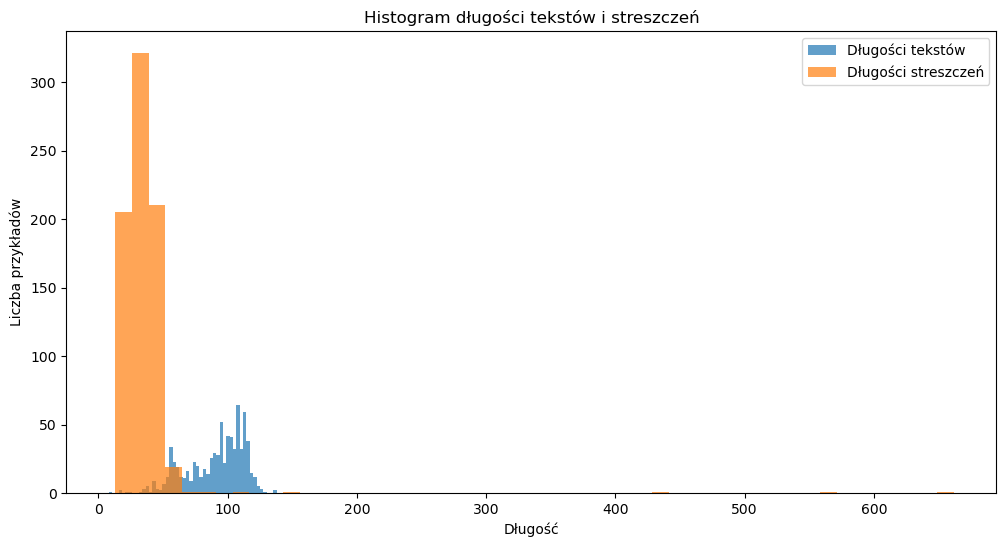

In [88]:
import matplotlib.pyplot as plt

# Histogramy
plt.figure(figsize=(12, 6))
plt.hist(text_len, bins=50, alpha=0.7, label="Długości tekstów")
plt.hist(summary_len, bins=50, alpha=0.7, label="Długości streszczeń")
plt.legend()
plt.title("Histogram długości tekstów i streszczeń")
plt.xlabel("Długość")
plt.ylabel("Liczba przykładów")
plt.show()


In [89]:
# Najdłuższy i najkrótszy artykuł
longest_article = max(df_train["article"], key=lambda x: words_count(x))
shortest_article = min(df_train["article"], key=lambda x: words_count(x))

print(f"Najdłuższy artykuł (liczba słów: {words_count(longest_article)}):\n{longest_article[:500]}...\n")
print(f"Najkrótszy artykuł (liczba słów: {words_count(shortest_article)}):\n{shortest_article[:500]}\n")

# Najdłuższe i najkrótsze streszczenie
longest_summary = max(df_train["highlights"], key=lambda x: words_count(x))
shortest_summary = min(df_train["highlights"], key=lambda x: words_count(x))

print(f"Najdłuższe streszczenie (liczba słów: {words_count(longest_summary)}):\n{longest_summary[:500]}...\n")
print(f"Najkrótsze streszczenie (liczba słów: {words_count(shortest_summary)}):\n{shortest_summary[:500]}\n")

Najdłuższy artykuł (liczba słów: 138):
By . Daily Mail Reporter . PUBLISHED: . 19:58 EST, 14 October 2013 . | . UPDATED: . 22:35 EST, 14 October 2013 . A very coordinated black bear at the Animal Ark Wildlife Sanctuary in Reno, Nevada, is a tetherball champ! The bear is seen swinging the ball around the pole for up to three minutes at a time. And, it obviously loves every moment. Scroll down for video... A big bear swipe: The black bear hits the ball . Watching it as it flies up and up and around . Woah, here it comes! Duck! The ball...

Najkrótszy artykuł (liczba słów: 8):
Downton Abbey's famously grim butler, Mr Bates .

Najdłuższe streszczenie (liczba słów: 662):
The Passat has been around for 42 years, the first model came out in 1973 .
The estate car is the fourth biggest-selling VW in the UK .
The new model has everything from keyless entry to heated seats .
Only diesel models will be on sale initially and there will be a beefed-up 4x4 version hitting the road in July .
It's hard

In [90]:
from collections import Counter

# Tokenizacja i liczenie słów
df_train['article_word_count'] = df_train['article'].apply(lambda x: words_count(x))
df_train['summary_word_count'] = df_train['highlights'].apply(lambda x: words_count(x))

# Najczęściej występujące słowa w streszczeniach
all_summaries = " ".join(df_train['highlights'])
word_counts = Counter(all_summaries.split())
print(word_counts.most_common(10))


[('.', 2095), ('the', 857), ('to', 627), ('of', 583), ('in', 550), ('a', 501), ('The', 421), ('and', 408), ('on', 359), ('is', 351)]


## Inżynieria cech

In [91]:
import re

def clean_text(text):
  text = re.sub(r'http[s]?://\S+', '', text)
  text = text.strip().replace('\n', ' ').replace('\r', ' ')
  text = re.sub(r'\s+', ' ', text)
  return text

train_data = ds['train'].filter(lambda row: len(row['article']) < cap)
train_data = train_data_map = train_data.map(lambda x: {'article': clean_text(x['article']), 'highlights': clean_text(x['highlights'])})
val_data = ds['validation'].filter(lambda row: len(row['article']) < cap).map(lambda x: {'article': clean_text(x['article']), 'highlights': clean_text(x['highlights'])})
test_data = ds['test'].filter(lambda row: len(row['article']) < cap).map(lambda x: {'article': clean_text(x['article']), 'highlights': clean_text(x['highlights'])})

train_data[:2], val_data[:2], test_data[:2]

Map: 100%|██████████| 29/29 [00:00<00:00, 7846.40 examples/s]


({'article': ["• The twins get a check-up (2/26/08) • VIDEO: Nancy Grace introduces on set 2-14-08 • The twins go out for a stroll (2/11/08) • The twins at 3 months (2/4/08) • The twins in January (1/21/08) • VIDEO: First video of Nancy Grace's twins E-mail to a friend .",
   "David C. Novak became chairman of the board at Yum! Brands on January 1, 2001, and chief executive officer on January 1, 2000. Yum! Brands's CEO, David Novak talks to CNN's Maggie Lake in The Boardroom. He also serves as president of Yum, a position he has held since October 21, 1997. Mr. Novak previously served as Group President and Chief Executive Officer, KFC and Pizza Hut from August 1996 to July 1997, at which time he became acting Vice Chairman of Yum. He is a director of J.P. Morgan Chase. Novak is a member of the Yum! Brands Executive committee. In his spare time Novak is a keen golfer and has even played a round with golf legend Tiger Woods. E-mail to a friend ."],
  'highlights': ["Pictures of Nancy Gr

In [92]:
from transformers import AutoTokenizer

model_name = "t5-small"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize_data(examples):
    inputs = [f"summarize: {article}" for article in examples['article']]
    targets = examples['highlights']

    model_inputs = tokenizer(
        inputs,
        max_length=512,
        truncation=True,
        padding="max_length",
        return_tensors="pt",
    )

    model_inputs['labels'] = tokenizer(
        targets,
        max_length=150,
        truncation=True,
        padding="max_length",
        return_tensors="pt",
    )['input_ids']

    return model_inputs

train_data_tokenized = train_data.map(
    tokenize_data,
    batched=True,
    remove_columns=['article', 'highlights'],
    batch_size=128,
)

val_data_tokenized = val_data.map(
    tokenize_data,
    batched=True,
    remove_columns=['article', 'highlights'],
    batch_size=128,
)

test_data_tokenized = test_data.map(
    tokenize_data,
    batched=True,
    remove_columns=['article', 'highlights'],
    batch_size=128,
)

train_data_tokenized = train_data_tokenized.with_format("torch")
val_data_tokenized = val_data_tokenized.with_format("torch")
test_data_tokenized = test_data_tokenized.with_format("torch")

print(train_data_tokenized[0])

Map: 100%|██████████| 29/29 [00:00<00:00, 2641.13 examples/s]


{'id': '9cce7373a54faccf5b5d1232c82afab9b29ab6b9', 'input_ids': tensor([21603,    10,  1697,    37,  7390,     7,   129,     3,     9,   691,
           18,   413,  4743,    87,  2688,    87,  4018,    61,  1697,   584,
        13162,   667,    10, 17117, 12254,  4277,     7,    30,   356,   204,
        11590,    18,  4018,  1697,    37,  7390,     7,   281,    91,    21,
            3,     9, 13593,  4743, 20223,    87,  4018,    61,  1697,    37,
         7390,     7,    44,   220,   767,  4743, 13572,    87,  4018,    61,
         1697,    37,  7390,     7,    16,  1762,    41, 17637, 12989,  4018,
           61,  1697,   584, 13162,   667,    10,  1485,   671,    13, 17117,
        12254,    31,     7,  7390,     7,   262,    18,  1963,    12,     3,
            9,  1565,     3,     5,     1,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,


In [93]:
train_data_tokenized

Dataset({
    features: ['id', 'input_ids', 'attention_mask', 'labels'],
    num_rows: 762
})

## Model

In [94]:
from evaluate import load

rouge = load("rouge")

def compute_metrics(p):
    predictions, labels = p
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
    result = rouge.compute(predictions=decoded_preds, references=decoded_labels)
    return result

In [95]:
from transformers import AutoModelForSeq2SeqLM, Seq2SeqTrainingArguments, Seq2SeqTrainer

model = AutoModelForSeq2SeqLM.from_pretrained(model_name)

training_args = Seq2SeqTrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    gradient_accumulation_steps=2,
    weight_decay=0.01,
    save_total_limit=3,
    num_train_epochs=5,
    predict_with_generate=True,
    logging_dir='./logs',
    logging_steps=100,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    save_steps=1000,
)

trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=train_data_tokenized,
    eval_dataset=val_data_tokenized,
    processing_class=tokenizer,
    compute_metrics=compute_metrics
)

trainer.train()

Epoch,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel,Rougelsum
1,No log,2.313884,0.192633,0.079197,0.158519,0.158664
2,No log,1.154938,0.000000,0.000000,0.000000,0.000000
3,No log,1.122937,0.000000,0.000000,0.000000,0.000000
4,No log,1.096797,0.000000,0.000000,0.000000,0.000000
5,2.641400,1.085906,0.000000,0.000000,0.000000,0.000000


There were missing keys in the checkpoint model loaded: ['encoder.embed_tokens.weight', 'decoder.embed_tokens.weight', 'lm_head.weight'].


TrainOutput(global_step=120, training_loss=2.3255007743835447, metrics={'train_runtime': 221.7282, 'train_samples_per_second': 17.183, 'train_steps_per_second': 0.541, 'total_flos': 515652263608320.0, 'train_loss': 2.3255007743835447, 'epoch': 5.0})

In [96]:
results = trainer.evaluate(eval_dataset=val_data_tokenized)
print(results)

{'eval_loss': 1.0859057903289795, 'eval_rouge1': 0.0, 'eval_rouge2': 0.0, 'eval_rougeL': 0.0, 'eval_rougeLsum': 0.0, 'eval_runtime': 1.6776, 'eval_samples_per_second': 14.902, 'eval_steps_per_second': 1.192, 'epoch': 5.0}


In [97]:
test_results = trainer.evaluate(eval_dataset=test_data_tokenized)
print(test_results)

{'eval_loss': 1.0151383876800537, 'eval_rouge1': 0.0, 'eval_rouge2': 0.0, 'eval_rougeL': 0.0, 'eval_rougeLsum': 0.0, 'eval_runtime': 2.3197, 'eval_samples_per_second': 12.502, 'eval_steps_per_second': 0.862, 'epoch': 5.0}


In [98]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Generating predictions for the test dataset
test_sample = test_data_tokenized[1]
decoded_input = tokenizer.decode(test_sample['input_ids'], skip_special_tokens=True)
print(decoded_input)

input_ids = test_sample['input_ids']
outputs = model.generate(input_ids=input_ids.unsqueeze(0), max_length=250, num_beams=4, no_repeat_ngram_size=2, temperature=1.0)
print(f"TYPE: type{outputs}")

# Decode predictions
decoded_output = tokenizer.decode(outputs[0], skip_special_tokens=True)
print(decoded_output)

summarize: London (CNN)A 19-year-old man was charged Wednesday with terror offenses after he was arrested as he returned to Britain from Turkey, London's Metropolitan Police said. Yahya Rashid, a UK national from northwest London, was detained at Luton airport on Tuesday after he arrived on a flight from Istanbul, police said. He's been charged with engaging in conduct in preparation of acts of terrorism, and with engaging in conduct with the intention of assisting others to commit acts of terrorism. Both charges relate to the period between November 1 and March 31. Rashid is due to appear in Westminster Magistrates' Court on Wednesday, police said. CNN's Lindsay Isaac contributed to this report.
TYPE: typetensor([[    0,     0,  4701,   107,    63,     9,  9053, 11740,     6, 12370,
            45, 24155,  1524,     6,    47, 10195,    44,  2318,    17,   106,
          3761,    30,  2818,     3,     5,   216,    31,     7,  4977,    28,
          7007,    16,  3498,    16,  4537,    

In [99]:
model.save_pretrained("./fine_tuned_model")
tokenizer.save_pretrained("./fine_tuned_model")

('./fine_tuned_model/tokenizer_config.json',
 './fine_tuned_model/special_tokens_map.json',
 './fine_tuned_model/tokenizer.json')